# **Flower Classification Competition (40%)**
For this competition, we will use the Flower Recognition (https://cloudstor.aarnet.edu.au/plus/s/1n6XuPUCwJ0MkgN). This dataset contains 4317 images of flowers. The data collection is based on the data flicr, google images, yandex images. You can use this datastet to recognize plants from the photo.  

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

We provide a baseline by the following steps:

*   Loding and Analysing the Flowers dataset using torchvision.
*   Defining a simple convolutional neural network. 
*   How to use existing loss function for the model learning. 
*   Train the network on the training data. 
*   Test the trained network on the testing data. 
*   Generate prediction for the random test image(s). 

The following trick/tweak(s) could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out. 
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.

Your code should be modified from the provided baseline. A pdf report is required to explain the tricks you employed, and the imporvements they achieved.
Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark = acc_mark + efficiency mark + report mark + bonus mark
###Acc_mark 15:

We will rank all the submission results based on their test accuracy. The top 30% of the students will get full marks.

|Accuracy|Mark|
|---|---|
| Top 30% in the class|          15|
|30%-50%|         11|
|50%-80%  |        7|
| 80%-90%  |      3|
| 90%-100%  |      1|
|Not implemented| 0|

###Efficiency mark 5:

Efficiency is evaluated by the computational costs (flops: https://en.wikipedia.org/wiki/FLOPS). Please report the computational costs for your final model and attach the code/process about how you calculate it.

|Efficiency|Mark|
|---|---|
| Top 30% in the class|          5|
|30%-50%|         4|
|50%-80%  |        3|
| 80%-90%  |      2|
| 90%-100%  |      2|
|Not implemented| 0|

###Report mark 20:
1. Introduction and your understanding to the baseline model: 2 points

2. Employed more than three tricks with ablation studies to improve the accuracy: 6 points

Clearly explain the reference, motivation and design choice for each trick/tweak(s). Providing the experimental results in tables.
Example table:

|Trick1|Trick2|Trick3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

Observation and discussion based on the experiment results.

3. Expaination of the methods on reducing the computational cost and/or improve the trade-off between accuracy and efficiency: 4 points

4. Explaination of the code implementation：3 points

5. Visulization results: e.g. training and testing accuracy/loss for each model, case studies: 3 points

6. Open ended:  Limitations, conclusions, failure cases analysis...: 2 points

###Bouns mark:
1. Top three results: 2 points
2. Fancy designs: 2 points

In [332]:
##################################################################################################################################
### Subject: Computer Vision 
### Year: 2022
### Student Name: ABC, XYZ
### Student ID: a123456, a654321
### Comptetion Name: Flowers Classification Competition
### Final Results:
### ACC:         FLOPs:
##################################################################################################################################

In [333]:
# Importing libraries. 

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

In [334]:
# Performing Image Transformations. 
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [335]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [336]:
# Mounting G-Drive to get your dataset. 
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU. 
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path.
data_directory = './flowers'
dataset=datasets.ImageFolder(root=data_directory,transform=train_transform)
dataset

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: ./flowers
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [337]:
# Checking the flower class types.
torch.manual_seed(10)
torch.cuda.manual_seed_all(10)
class_names=dataset.classes
print(class_names)
print(len(class_names))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
5


In [338]:
# Train and Test data split. 
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

In [339]:
train_loader1=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader1=DataLoader(test_data,batch_size=10)

In [340]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_loader = DeviceDataLoader(train_loader1, device)
test_loader = DeviceDataLoader(test_loader1, device)

In [341]:
print(len(train_data))
print(len(test_data))

3453
864


In [342]:
# Preview of the datasets. 
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.cpu().numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [0 1 0 3 0 4 1 2 1 3]
Class: daisy dandelion daisy sunflower daisy tulip dandelion rose dandelion sunflower


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


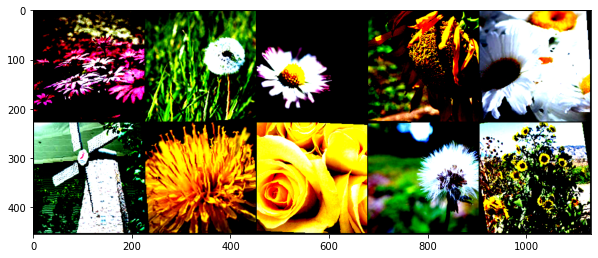

In [343]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.cpu().numpy(),(1,2,0)))

In [344]:
# Inverse Normalization. 
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                     std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

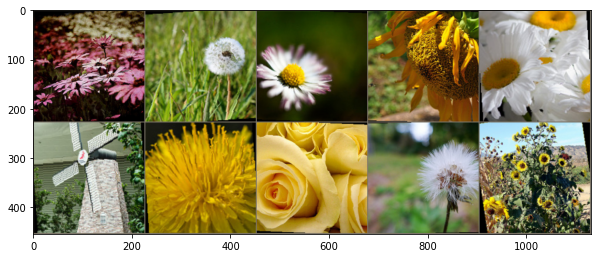

In [345]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.cpu().numpy(),(1,2,0)))

In [346]:
# Convolutional Network - Baseline
# class ConvolutionalNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1=nn.Conv2d(3,6,3,1)
#         self.conv2=nn.Conv2d(6,16,3,1)
#         self.fc1=nn.Linear(16*54*54,120) 
#         self.fc2=nn.Linear(120,84)
#         self.fc3=nn.Linear(84,20)
#         self.fc4=nn.Linear(20,5)
#     def forward(self,X):
#         X=F.relu(self.conv1(X))
#         X=F.max_pool2d(X,2,2)
#         X=F.relu(self.conv2(X))
#         X=F.max_pool2d(X,2,2)
#         X=X.view(-1,16*54*54)
#         X=F.relu(self.fc1(X))
#         X=F.relu(self.fc2(X))
#         X=F.relu(self.fc3(X))
#         X=self.fc4(X)
        
#         return F.log_softmax(X, dim=1)


# CNNmodel=ConvolutionalNetwork().to(device)
# criterion=nn.CrossEntropyLoss()
# optimizer=torch.optim.Adam(CNNmodel.parameters(),lr=0.001)


In [347]:
#resnet18

# class BasicBlock(nn.Module):
#     def __init__(self,in_channels,out_channels,kernel_size,stride):
#         super(BasicBlock,self).__init__()
#         self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding=1)
#         self.bn1=nn.BatchNorm2d(out_channels)
#         self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size,stride,padding=1)
#         self.bn2=nn.BatchNorm2d(out_channels)
        
#     def forward(self,x):
#         output=self.bn1(self.conv1(x))
#         output=self.bn2(self.conv2(output))
#         return F.relu(x+output)

# class BasicDownBlock(nn.Module):
#     def __init__(self,in_channels,out_channels,kernel_size,stride):
#         super(BasicDownBlock,self).__init__()     
#         self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size[0],stride[0],padding=1)
#         self.bn1=nn.BatchNorm2d(out_channels)
#         self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size[0],stride[1],padding=1)
#         self.bn2=nn.BatchNorm2d(out_channels)
#         self.conv3=nn.Conv2d(in_channels,out_channels,kernel_size[1],stride[0])
#         self.bn3=nn.BatchNorm2d(out_channels)
        
#     def forward(self,x):
#         output=self.bn1(self.conv1(x))
#         output=self.bn2(self.conv2(output))
#         output1=self.bn3(self.conv3(x))
#         return F.relu(output1+output)

# class ConvolutionalNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # 3x224x224-->64x112x112
#         self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3)
#         self.bn1=nn.BatchNorm2d(64)
#         # 64x112x112-->64x56x56
#         self.pool1=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
#         # 64x56x56-->64x56x56
#         self.layer1=nn.Sequential(
#             BasicBlock(64,64,3,1),
#             BasicBlock(64,64,3,1)
#         )
#         # 64x56x56-->128*28*28
#         self.layer2=nn.Sequential(
#             BasicDownBlock(64,128,[3,1],[2,1]),
#             BasicBlock(128,128,3,1)
#         )
#         # 128*28*28-->256*14*14
#         self.layer3=nn.Sequential(
#             BasicDownBlock(128,256,[3,1],[2,1]),
#             BasicBlock(256,256,3,1)
#         )
#         # 256*14*14-->512x7x7
#         self.layer4=nn.Sequential(
#             BasicDownBlock(256,512,[7,1],[2,1]),
#             BasicBlock(512,512,3,1)
#         )
#         # 512x7x7-->512x1x1
#         self.avgpool=nn.AdaptiveMaxPool2d(output_size=(1,1))
#         self.flat=nn.Flatten()
#         self.linear=nn.Linear(512,5)
        
#     def forward(self,x):
#         output=self.pool1(F.relu(self.bn1(self.conv1(x))))
#         output=self.layer1(output)
#         output=self.layer2(output)
#         output=self.layer3(output)
#         output=self.layer4(output)
#         output=self.avgpool(output)
#         output=self.flat(output)
#         output=self.linear(output)
#         return F.log_softmax(output, dim=1)

# num_classes = 5
# CNNmodel=ConvolutionalNetwork().to(device)
# criterion=nn.CrossEntropyLoss()
# optimizer=torch.optim.Adam(CNNmodel.parameters(),lr=0.001)



In [348]:
#resnet18-pre-training

# import  torch
# from    torch import nn
# from    torchvision.models import resnet18
# from    torchvision.models import resnet34

# class Flatten(nn.Module):

#     def __init__(self):
#         super(Flatten, self).__init__()

#     def forward(self, x):
#         shape = torch.prod(torch.tensor(x.shape[1:])).item()
#         return x.view(-1, shape)


# class ConvolutionalNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(*list(resnet18(pretrained=True).children())[:-1], #[b, 512, 1, 1]
#                           Flatten() # [b, 512, 1, 1] => [b, 512]
                          
#                           )       
#         self.fc = nn.Linear(512, 5)
#     def forward(self,X):
#         X=self.features(X)
#         X=self.fc(X)
#         return F.log_softmax(X, dim=1)

# num_classes = 5
# CNNmodel=ConvolutionalNetwork().to(device)
# criterion=nn.CrossEntropyLoss()
# optimizer=torch.optim.Adam(CNNmodel.parameters(),lr=0.001)


In [349]:
#resnet18-pre-training+SGD+same lr

# import  torch
# from    torch import nn
# from    torchvision.models import resnet18
# from    torchvision.models import resnet34

# class Flatten(nn.Module):

#     def __init__(self):
#         super(Flatten, self).__init__()

#     def forward(self, x):
#         shape = torch.prod(torch.tensor(x.shape[1:])).item()
#         return x.view(-1, shape)


# class ConvolutionalNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(*list(resnet18(pretrained=True).children())[:-1], #[b, 512, 1, 1]
#                           Flatten() # [b, 512, 1, 1] => [b, 512]
                          
#                           )       
#         self.fc = nn.Linear(512, 5)
#     def forward(self,X):
#         X=self.features(X)
#         X=self.fc(X)
#         return F.log_softmax(X, dim=1)

# num_classes = 5
# CNNmodel=ConvolutionalNetwork().to(device)
# criterion=nn.CrossEntropyLoss()
# optimizer=torch.optim.SGD(CNNmodel.parameters(),lr=0.001)


In [350]:
#resnet18-pre-training+SGD+different lr

import  torch
from    torch import nn
from    torchvision.models import resnet18
from    torchvision.models import resnet34

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(*list(resnet18(pretrained=True).children())[:-1], #[b, 512, 1, 1]
                          Flatten() # [b, 512, 1, 1] => [b, 512]
                          
                          )       
        self.fc = nn.Linear(512, 5)
    def forward(self,X):
        X=self.features(X)
        X=self.fc(X)
        return F.log_softmax(X, dim=1)

num_classes = 5
CNNmodel=ConvolutionalNetwork().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD([ 
{'params': CNNmodel.features.parameters(),'lr': 0.001, 'momentum':0.9}, 
{'params': CNNmodel.fc.parameters(),'lr': 0.01,'momentum':0.3}
])

In [351]:
CNNmodel

ConvolutionalNetwork(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [352]:
# Counting of number of parameters in the model.
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(CNNmodel)

    9408
      64
      64
   36864
      64
      64
   36864
      64
      64
   36864
      64
      64
   36864
      64
      64
   73728
     128
     128
  147456
     128
     128
    8192
     128
     128
  147456
     128
     128
  147456
     128
     128
  294912
     256
     256
  589824
     256
     256
   32768
     256
     256
  589824
     256
     256
  589824
     256
     256
 1179648
     512
     512
 2359296
     512
     512
  131072
     512
     512
 2359296
     512
     512
 2359296
     512
     512
    2560
       5
________
11179077


In [353]:
# Learning Schema.
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=25

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1                                            
        y_pred=CNNmodel(X_train)
        loss=criterion(y_pred,y_train)

        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if b%200==0:
            #print(f"train: epoch: {i} loss: {loss.item} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
        
    loss=loss.detach().cpu().numpy()
    trn_corr=trn_corr.cpu().numpy()
    trn_corr=trn_corr*100/3453
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1
            y_val=CNNmodel(X_test)
            loss=criterion(y_val,y_test)
            
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr
            
                

        print(f"test: epoch: {i} loss: {loss.item} batch: {b} accuracy: {tst_corr.item()*100/(10*b):7.3f}%")
        loss=loss.detach().cpu().numpy()
        tst_corr=tst_corr.cpu().numpy()
        tst_corr=tst_corr*100/864
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

test: epoch: 0 loss: <built-in method item of Tensor object at 0x7ffaeb642450> batch: 87 accuracy:  87.701%
test: epoch: 1 loss: <built-in method item of Tensor object at 0x7ffae9c6a0e0> batch: 87 accuracy:  84.368%
test: epoch: 2 loss: <built-in method item of Tensor object at 0x7ffaeb869a40> batch: 87 accuracy:  88.046%
test: epoch: 3 loss: <built-in method item of Tensor object at 0x7ffaeae1bf40> batch: 87 accuracy:  88.851%
test: epoch: 4 loss: <built-in method item of Tensor object at 0x7ffaeb6429f0> batch: 87 accuracy:  88.391%
test: epoch: 5 loss: <built-in method item of Tensor object at 0x7ffaeb642450> batch: 87 accuracy:  90.115%
test: epoch: 6 loss: <built-in method item of Tensor object at 0x7ffae9a63950> batch: 87 accuracy:  90.115%
test: epoch: 7 loss: <built-in method item of Tensor object at 0x7ffaeb6429f0> batch: 87 accuracy:  89.425%
test: epoch: 8 loss: <built-in method item of Tensor object at 0x7ffaeb641f40> batch: 87 accuracy:  89.195%
test: epoch: 9 loss: <built-

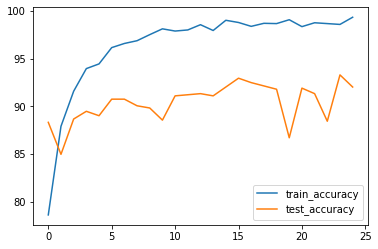

In [354]:
# Plotting accuracy over time. 
plt.plot(train_correct,label="train_accuracy")
plt.plot(test_correct,label="test_accuracy")
plt.legend()
plt.savefig("accuracy.png")

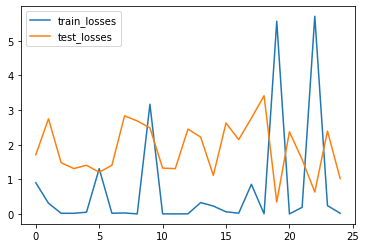

In [355]:
# Plotting loss over time. 
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()
plt.savefig("loss.png")

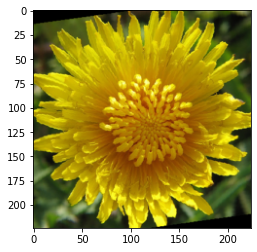

In [356]:
x=100
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [357]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [358]:
# Prediction for one of the samples. 
CNNmodel.eval()
with torch.no_grad():
    new_pred=CNNmodel(test_data[x][0].view(1,3,224,224).to(device)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 dandelion


##FLOPs

In [359]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

--2022-06-20 17:55:50--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=tga7f1ogh0tnjiosvnl5of80c0; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=A1IXme3IDXWhDAL%2BtH4oxGA4CFVbQm4HMBBjCXikTqlRtyqL9WNqaMP170RnJnn5AN9w%2B6MUAZMfVf6CzQQkGkyx8%2B4tyes1g%2BHy%2BKMEHW9v2tODcU7B3ogFObyraJ1Z; path=/plus;; Secure at position 172.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-06-20 17:55:51 (278 MB/s) - ‘download’ saved [5201/5201]



In [360]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 5
model = ConvolutionalNetwork()
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 3.59G
